# Entrenamiento para identificar la tipología fotográfica usando TensorFlow 2.x
![Tipologías fotograficas](imagenes/tipologias.jpg)

Este cuaderno usa transferencia de aprendizaje con TensorFlow 2 y MobileNetV2.

Asegúrate de tener `tensorflow`, `tensorflow_hub` y `matplotlib` instalados:
```python
!pip install tensorflow tensorflow_hub matplotlib
```

In [1]:
# Importaciones necesarias
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers

# Comprobar versión de TensorFlow

In [2]:
print(tf.__version__)

2.18.0


CLONAR SOLO EL CONJUNTO DE DATOS

In [4]:
!git clone https://github.com/gustavolsj/ds_tipologias

Cloning into 'ds_tipologias'...
remote: Enumerating objects: 488, done.
remote: Total 488 (delta 0), reused 0 (delta 0), pack-reused 488 (from 1)
Receiving objects: 100% (488/488), 367.22 MiB | 34.86 MiB/s, done.
Updating files: 100% (476/476), done.
ls: cannot access 'testing/': No such file or directory


In [15]:
cd ds_tipologias


/content/ds_tipologias


In [26]:
!ls

testing  training


# Preparación de los datos
Tus imágenes deben estar en carpetas tipo:
`tf_files/training/<clase>/*.jpg` y `tf_files/testing/<clase>/*.jpg`

In [17]:
train_dir = 'training'
test_dir = 'testing'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print('Clases:', class_names)

Found 437 files belonging to 4 classes.
Found 39 files belonging to 4 classes.
Clases: ['Imagen_de_camara', 'Impresion', 'Negativo', 'Transparencia']


# Visualizar algunas imágenes

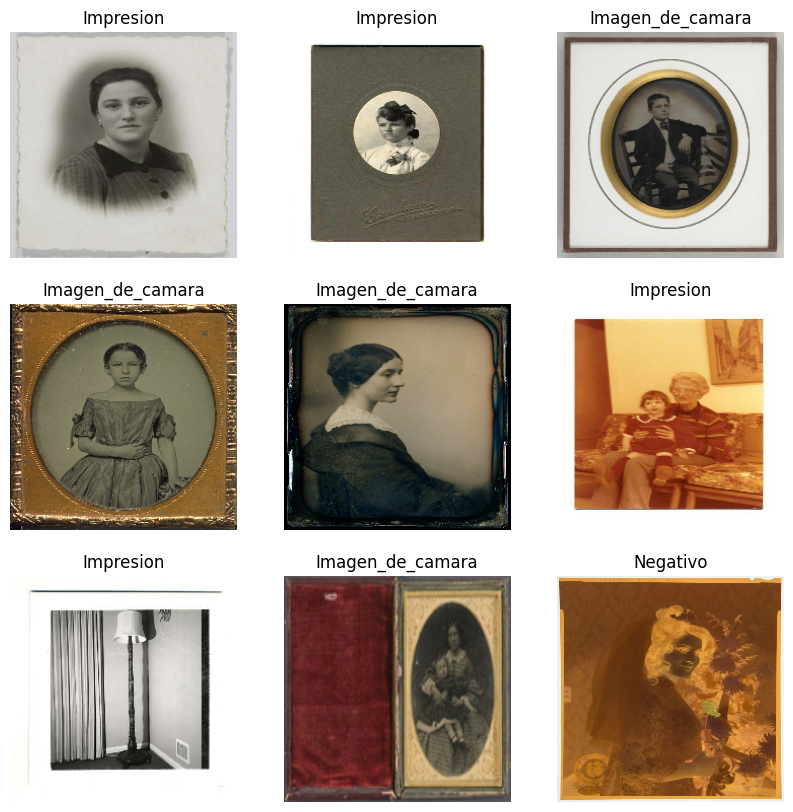

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Crear el modelo con MobileNetV2 y capa densa nueva

In [19]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
base_model.trainable = False

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [22]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenamiento

In [23]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3552 - loss: 0.7636 - val_accuracy: 0.2821 - val_loss: -0.0024
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2838 - loss: 0.6231 - val_accuracy: 0.2564 - val_loss: -0.2068
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2665 - loss: 0.5381 - val_accuracy: 0.2308 - val_loss: -0.3408
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2885 - loss: 0.4586 - val_accuracy: 0.2308 - val_loss: -0.4632
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.2794 - loss: 0.2982 - val_accuracy: 0.2051 - val_loss: -0.5669


# Guardar el modelo entrenado y las etiquetas

In [ ]:
model.save('retrained_model.keras')
with open('retrained_labels.txt', 'w') as f:
    for label in class_names:
        f.write(label + '\n')

# Clasificar una imagen de prueba

In [24]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(img_path):
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 0)  # batch size 1
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    print(f"Predicción: {class_names[pred_idx]} (confianza: {preds[0][pred_idx]:.2f})")
    plt.imshow(img)
    plt.title(f"Predicción: {class_names[pred_idx]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicción: Imagen_de_camara (confianza: 0.58)


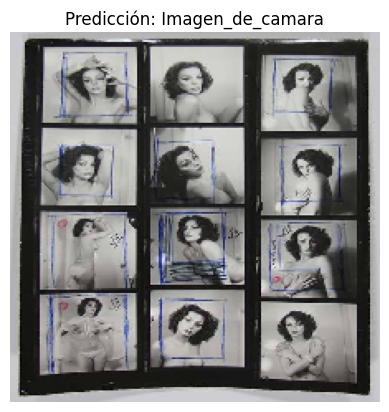

In [27]:
# Ejemplo de uso
predict_image(img_path='testing/Impresion/04.jpg')